In [1]:
# this script is for mapping PDBs structures to MSAs of orthologs kinases proteins

In [2]:
import pandas as pd
import pyranges as pr
import matplotlib.pyplot as plt

In [3]:
# Load data
# Sift dataset
sift = pd.read_csv('../datasets/uniprot_segments_observed.tsv.gz', sep= '\t', compression= 'gzip', skiprows= 1)
sift.columns = sift.columns.str.lower()
# Drop individual observed residues
sift = sift[sift.sp_beg != sift.sp_end]

# dataset with KD and CRE region coordinates
kd = pd.read_csv('../datasets/kd.tsv', sep= '\t')
cre = pd.read_csv('../datasets/cre.tsv', sep= '\t')
regions = kd.merge(cre, on= 'uniprot_acc', suffixes= ["_kd", "_cre"])

In [4]:
# sift data with start and end in uniprot sequence
sift_ = sift[['sp_primary', 'pdb','sp_beg', 'sp_end']].drop_duplicates()
sift_ = sift_.sort_values("sp_primary")
sift_

,sp_primary,pdb,sp_beg,sp_end
37784,A0A003,6kvc,13,48
37751,A0A003,6kv9,13,49
37752,A0A003,6kv9,59,320
37785,A0A003,6kvc,59,321
112426,A0A009I821,7ryg,1,109
...,...,...,...,...
204109,X7YCN8,5vba,16,46
204111,X7YCN8,5vba,107,170
204110,X7YCN8,5vba,51,104
78144,X8CHM4,5o5k,210,425


In [5]:
# Create a unique range for each PDB (instead of splited by segments)
# Get the min value of coordinates for each pdb
pdb_min = sift_.groupby(['sp_primary', 'pdb']).min().reset_index().drop(columns= 'sp_end')
# Get the max value of coordinates for each pdb
pdb_max = sift_.groupby(['sp_primary', 'pdb']).max().reset_index().drop(columns= 'sp_beg')
pdb_coord = pdb_min.merge(pdb_max) # ok!!

In [6]:
# # Regions "global range", start and end including both KD and CRE
# regions_gl = regions[['uniprot_acc', 'term_id_kd', 'term_id_cre']].copy()
# regions_gl["start"] = regions_gl['end'] = 0
# for i in regions.index:
#     coords = [regions.start_cre[i], regions.end_cre[i], regions.start_kd[i], regions.end_kd[i]].sort()
    
#     start = min(coords)
#     end = max(coords)
#     regions_gl['start'][i] = start
#     regions_gl['end'][i] = end

In [7]:
#regions_gl

In [8]:
#regions_gl.nunique() # Ok

## pyranges join

In [9]:
# # MERGE both tables
# # Convert regions df to pyranges object
# regions_gl.rename(columns= {'uniprot_acc': 'Chromosome' }, inplace= True)
# regions_gl.columns = regions_gl.columns.str.capitalize()
# regions_gl["length"] = regions_gl.End - regions_gl.Start + 1
# # As pyranges object
# regions_gl_pr = pr.PyRanges(regions_gl)

# # PDBs coordinates as pyranges object
# pdb_pr = pr.PyRanges(pdb_coord.rename(
#     columns= {
#         'sp_primary': 'Chromosome',
#         'sp_beg': 'Start',
#         'sp_end': 'End'
#     }
# )
# )

In [10]:
# Convert regions dfs to pyranges object
kd["length"] = kd.end - kd.start + 1
kd.rename(columns= {'uniprot_acc': 'Chromosome'}, inplace= True)
kd.columns = kd.columns.str.capitalize()
# As pyranges object
kd = pr.PyRanges(kd)

cre["length"] = cre.end - cre.start + 1
cre.rename(columns= {'uniprot_acc': 'Chromosome'}, inplace= True)
cre.columns = cre.columns.str.capitalize()
# As pyranges object
cre = pr.PyRanges(cre)

# PDBs coordinates as pyranges object
pdb_pr = pr.PyRanges(pdb_coord.rename(
    columns= {
        'sp_primary': 'Chromosome',
        'sp_beg': 'Start',
        'sp_end': 'End'
    }
)
)

In [11]:
# # With intersect the returned intervals are the intersection 
# # of the overlapping intervals in self and other. All overlaps are returned by default
# regions_pdb_both = regions_gl_pr.intersect(pdb_pr)
# regions_pdb_both = regions_pdb_both.as_df()
# regions_pdb_both.columns = regions_pdb_both.columns.str.lower()
# regions_pdb_both.rename(columns= {'chromosome': 'uniprot'}, inplace= True)
# regions_pdb_both

In [12]:
# # Join pyranges method
# regions_pdb_both = regions_gl_pr.join(pdb_pr, slack= 1, suffix= "_pdb", report_overlap= True) # slack= 1 includes sequence edges
# regions_pdb_both = regions_pdb_both.as_df()
# regions_pdb_both.columns = regions_pdb_both.columns.str.lower()
# regions_pdb_both.rename(columns= {'chromosome': 'uniprot'}, inplace= True)
# regions_pdb_both

In [13]:
# Join
cre = cre.join(pdb_pr, slack= 1, suffix= "_pdb", report_overlap= True) # slack= 1 includes sequence edges)
cre = cre.as_df()
cre.columns = cre.columns.str.lower()
cre.rename(columns= {'chromosome': 'uniprot'}, inplace= True)

kd = kd.join(pdb_pr, slack= 1, suffix= "_pdb", report_overlap= True) # slack= 1 includes sequence edges)
kd = kd.as_df()
kd.columns = kd.columns.str.lower()
kd.rename(columns= {'chromosome': 'uniprot'}, inplace= True)

del(pdb_pr)

In [14]:
# Format columns
cre = cre.rename(
    columns= {
        'start': 'start_cre',
        'end': 'end_cre',
        'term_id': 'term_id_cre',
        'length': 'length_cre',
        'overlap': 'overlap_cre'
    }
)
kd = kd.rename(
    columns= {
        'start': 'start_kd',
        'end': 'end_kd',
        'term_id': 'term_id_kd',
        'length': 'length_kd',
        'overlap': 'overlap_kd'
    }
)

In [15]:
pdb_both_regions = cre.merge(kd)
pdb_both_regions

,uniprot,start_cre,end_cre,term_id_cre,length_cre,pdb,start_pdb,end_pdb,overlap_cre,start_kd,end_kd,term_id_kd,length_kd,overlap_kd
0,A5K0N4,1,22,cre10,22,5f0a,1,846,22,534,791,kd10,258,259
1,A5K0N4,1,22,cre10,22,5dzc,1,843,22,534,791,kd10,258,259
2,A5K0N4,1,22,cre10,22,5dyl,1,816,22,534,791,kd10,258,259
3,A5K0N4,1,22,cre10,22,4rz7,1,815,22,534,791,kd10,258,259
4,A5K0N4,1,22,cre10,22,5fet,2,816,21,534,791,kd10,258,259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,Q16644,344,382,cre142,39,3r1n,33,348,5,44,304,kd142,261,262
835,Q16644,344,382,cre142,39,3she,33,348,5,44,304,kd142,261,262
836,Q61846,326,643,cre178,318,4bfm,2,326,1,11,263,kd178,253,254
837,Q61846,326,643,cre178,318,4cqg,2,326,1,11,263,kd178,253,254


In [16]:
pdb_both_regions.nunique()

uniprot         51
start_cre       40
end_cre         44
term_id_cre     53
length_cre      36
pdb            832
start_pdb      139
end_pdb        169
overlap_cre     59
start_kd        39
end_kd          42
term_id_kd      51
length_kd       21
overlap_kd      30
dtype: int64

In [17]:
#regions_pdb_both.nunique() # 102 out of 280 proteins have 1904 PDB structures

In [18]:
# Cuantos PDB cubren totalmente ambas regiones?
#regions_pdb_both[regions_pdb_both.length == regions_pdb_both.overlap].pdb.nunique()

In [19]:
#regions_pdb_both[regions_pdb_both.length == regions_pdb_both.overlap].uniprot.nunique()

In [20]:
# Cuantos cubren parcialmente
#regions_pdb_both[regions_pdb_both.length != regions_pdb_both.overlap].pdb.nunique()

In [21]:
# No. of unique proteins
#regions_pdb_both.uniprot.nunique()

In [22]:
# No. of unique pdbs
#regions_pdb_both.pdb.nunique()

In [23]:
# Add which MSA belongs each pdb
all_msa = pd.read_csv('../datasets/all_msas.tsv', sep= '\t')
# only 60% identity
all_msa = all_msa[all_msa.msa.str.endswith("60")]

In [24]:
# Mapping MSA - uniprot
to_add = all_msa.drop(columns= 'length_msa')#.uniprot.nunique()

In [25]:
msa_regions_pdbs = pdb_both_regions.merge(to_add, how= 'left') #left_on='uniprot', right_on= 'uniprot'
msa_regions_pdbs

,uniprot,start_cre,end_cre,term_id_cre,length_cre,pdb,start_pdb,end_pdb,overlap_cre,start_kd,end_kd,term_id_kd,length_kd,overlap_kd,msa
0,A5K0N4,1,22,cre10,22,5f0a,1,846,22,534,791,kd10,258,259,Q8I719_60
1,A5K0N4,1,22,cre10,22,5f0a,1,846,22,534,791,kd10,258,259,A5K0N4_60
2,A5K0N4,1,22,cre10,22,5dzc,1,843,22,534,791,kd10,258,259,Q8I719_60
3,A5K0N4,1,22,cre10,22,5dzc,1,843,22,534,791,kd10,258,259,A5K0N4_60
4,A5K0N4,1,22,cre10,22,5dyl,1,816,22,534,791,kd10,258,259,Q8I719_60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,Q16644,344,382,cre142,39,3she,33,348,5,44,304,kd142,261,262,Q16644_60
941,Q61846,326,643,cre178,318,4bfm,2,326,1,11,263,kd178,253,254,Q61846_60
942,Q61846,326,643,cre178,318,4cqg,2,326,1,11,263,kd178,253,254,Q61846_60
943,Q63450,285,312,cre183,28,1a06,10,316,29,20,276,kd183,257,258,Q91YS8_60


In [26]:
msa_regions_pdbs.isna().any()

uniprot        False
start_cre      False
end_cre        False
term_id_cre    False
length_cre     False
pdb            False
start_pdb      False
end_pdb        False
overlap_cre    False
start_kd       False
end_kd         False
term_id_kd     False
length_kd      False
overlap_kd     False
msa             True
dtype: bool

In [27]:
msa_regions_pdbs[msa_regions_pdbs.msa.isna()].uniprot.nunique()

2

In [28]:
msa_regions_pdbs.columns

Index(['uniprot', 'start_cre', 'end_cre', 'term_id_cre', 'length_cre', 'pdb',
       'start_pdb', 'end_pdb', 'overlap_cre', 'start_kd', 'end_kd',
       'term_id_kd', 'length_kd', 'overlap_kd', 'msa'],
      dtype='object')

In [29]:
msa_regions_pdbs = msa_regions_pdbs.dropna()
msa_regions_pdbs = msa_regions_pdbs.loc[:, ['msa', 'uniprot', 'start_cre', 'end_cre', 'term_id_cre', 'length_cre', 'pdb',
       'start_pdb', 'end_pdb', 'overlap_cre', 'start_kd', 'end_kd',
       'term_id_kd', 'length_kd', 'overlap_kd']].sort_values(["msa", 'uniprot'])
msa_regions_pdbs

,msa,uniprot,start_cre,end_cre,term_id_cre,length_cre,pdb,start_pdb,end_pdb,overlap_cre,start_kd,end_kd,term_id_kd,length_kd,overlap_kd
1,A5K0N4_60,A5K0N4,1,22,cre10,22,5f0a,1,846,22,534,791,kd10,258,259
3,A5K0N4_60,A5K0N4,1,22,cre10,22,5dzc,1,843,22,534,791,kd10,258,259
5,A5K0N4_60,A5K0N4,1,22,cre10,22,5dyl,1,816,22,534,791,kd10,258,259
7,A5K0N4_60,A5K0N4,1,22,cre10,22,4rz7,1,815,22,534,791,kd10,258,259
9,A5K0N4_60,A5K0N4,1,22,cre10,22,5fet,2,816,21,534,791,kd10,258,259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,Q9UIK4_60,Q9UIK4,292,301,cre273,10,2cke,11,311,11,23,285,kd273,263,264
774,Q9UIK4_60,Q9UIK4,292,301,cre273,10,1wmk,12,325,11,23,285,kd273,263,264
776,Q9UIK4_60,Q9UIK4,292,301,cre273,10,2a27,12,315,11,23,285,kd273,263,264
778,Q9UIK4_60,Q9UIK4,292,301,cre273,10,1z9x,12,314,11,23,285,kd273,263,264


In [30]:
def stats_df(df):
    return print(f"There are {df.uniprot.nunique()} proteins in {df.msa.nunique()} MSAs containing {df.pdb.nunique()} PDB structures")

In [31]:
stats_df(msa_regions_pdbs)

There are 49 proteins in 58 MSAs containing 830 PDB structures


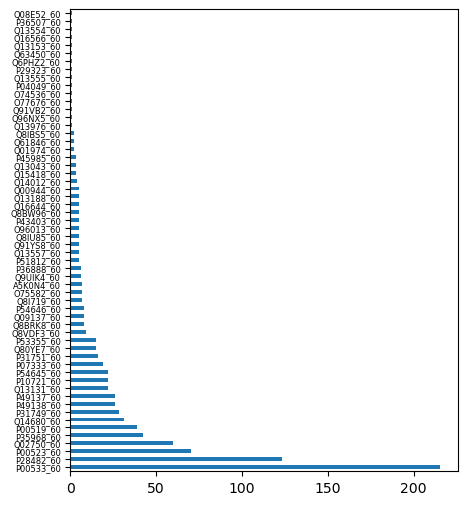

In [32]:
plt.figure(figsize= (5, 6))
msa_regions_pdbs.msa.value_counts().plot(kind= 'barh')
plt.yticks(size= 6)
plt.show()

In [33]:
# MSAs with 2 or more proteins
filter = (msa_regions_pdbs.msa.value_counts()[msa_regions_pdbs.msa.value_counts() > 1]).index.to_list()
msa_regions_pdbs_filtered = msa_regions_pdbs[msa_regions_pdbs.msa.isin(filter)]

In [34]:
stats_df(msa_regions_pdbs_filtered)

There are 39 proteins in 43 MSAs containing 820 PDB structures


In [35]:
msa_regions_pdbs_filtered.msa

1      A5K0N4_60
3      A5K0N4_60
5      A5K0N4_60
7      A5K0N4_60
9      A5K0N4_60
         ...    
772    Q9UIK4_60
774    Q9UIK4_60
776    Q9UIK4_60
778    Q9UIK4_60
780    Q9UIK4_60
Name: msa, Length: 926, dtype: object

In [36]:
msa_regions_pdbs_filtered[msa_regions_pdbs_filtered.msa == 'Q9UIK4_60'].pdb.to_list()

['2a2a', '2cke', '1wmk', '2a27', '1z9x', '6paw']

In [37]:
msa_regions_pdbs_filtered[msa_regions_pdbs_filtered.pdb.isin(['1z9x', '1wmk', '6paw', '2cke', '2a27', '2a2a'])]

,msa,uniprot,start_cre,end_cre,term_id_cre,length_cre,pdb,start_pdb,end_pdb,overlap_cre,start_kd,end_kd,term_id_kd,length_kd,overlap_kd
771,Q8VDF3_60,Q9UIK4,292,301,cre273,10,2a2a,11,314,11,23,285,kd273,263,264
773,Q8VDF3_60,Q9UIK4,292,301,cre273,10,2cke,11,311,11,23,285,kd273,263,264
775,Q8VDF3_60,Q9UIK4,292,301,cre273,10,1wmk,12,325,11,23,285,kd273,263,264
777,Q8VDF3_60,Q9UIK4,292,301,cre273,10,2a27,12,315,11,23,285,kd273,263,264
779,Q8VDF3_60,Q9UIK4,292,301,cre273,10,1z9x,12,314,11,23,285,kd273,263,264
781,Q8VDF3_60,Q9UIK4,292,301,cre273,10,6paw,14,329,11,23,285,kd273,263,264
770,Q9UIK4_60,Q9UIK4,292,301,cre273,10,2a2a,11,314,11,23,285,kd273,263,264
772,Q9UIK4_60,Q9UIK4,292,301,cre273,10,2cke,11,311,11,23,285,kd273,263,264
774,Q9UIK4_60,Q9UIK4,292,301,cre273,10,1wmk,12,325,11,23,285,kd273,263,264
776,Q9UIK4_60,Q9UIK4,292,301,cre273,10,2a27,12,315,11,23,285,kd273,263,264


In [64]:
# MSAs con mas de 100 seqs (para coevol analysis)
msa_60 = all_msa.msa.value_counts().reset_index().rename(columns= {'index': 'msa', 'msa': 'length_msa'})
msa_60 = msa_60[msa_60.length_msa > 100]

In [65]:
len(msa_60)

30

In [72]:
#msa_60.msa.to_csv('../datasets/msas_more_100seqs.txt', index= False)

In [67]:
msa_60.merge(msa_regions_pdbs, how= 'left')

,msa,length_msa,uniprot,start_cre,end_cre,term_id_cre,length_cre,pdb,start_pdb,end_pdb,overlap_cre,start_kd,end_kd,term_id_kd,length_kd,overlap_kd
0,Q00771_60,273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,O43318_60,137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Q8BRK8_60,137,P54646,291.0,376.0,cre100,86.0,7myj,7.0,551.0,87.0,16.0,268.0,kd100,253.0,254.0
3,Q8BRK8_60,137,P54646,291.0,376.0,cre100,86.0,6b1u,8.0,552.0,87.0,16.0,268.0,kd100,253.0,254.0
4,Q8BRK8_60,137,P54646,291.0,376.0,cre100,86.0,4cfe,8.0,551.0,87.0,16.0,268.0,kd100,253.0,254.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,O75582_60,101,O75582,702.0,723.0,cre22,22.0,7up4,415.0,728.0,23.0,426.0,687.0,kd23,262.0,263.0
285,O75582_60,101,O75582,702.0,723.0,cre22,22.0,7up5,415.0,728.0,23.0,426.0,687.0,kd23,262.0,263.0
286,O75582_60,101,O75582,702.0,723.0,cre22,22.0,7up7,415.0,728.0,23.0,426.0,687.0,kd23,262.0,263.0
287,O75582_60,101,O75582,702.0,723.0,cre22,22.0,7up8,415.0,727.0,23.0,426.0,687.0,kd23,262.0,263.0


In [47]:
prueba = msa_regions_pdbs.merge(msa_60)
prueba

,msa,uniprot,start_cre,end_cre,term_id_cre,length_cre,pdb,start_pdb,end_pdb,overlap_cre,start_kd,end_kd,term_id_kd,length_kd,overlap_kd,length_msa
0,A5K0N4_60,A5K0N4,1,22,cre10,22,5f0a,1,846,22,534,791,kd10,258,259,9
1,A5K0N4_60,A5K0N4,1,22,cre10,22,5dzc,1,843,22,534,791,kd10,258,259,9
2,A5K0N4_60,A5K0N4,1,22,cre10,22,5dyl,1,816,22,534,791,kd10,258,259,9
3,A5K0N4_60,A5K0N4,1,22,cre10,22,4rz7,1,815,22,534,791,kd10,258,259,9
4,A5K0N4_60,A5K0N4,1,22,cre10,22,5fet,2,816,21,534,791,kd10,258,259,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,Q9UIK4_60,Q9UIK4,292,301,cre273,10,2cke,11,311,11,23,285,kd273,263,264,63
937,Q9UIK4_60,Q9UIK4,292,301,cre273,10,1wmk,12,325,11,23,285,kd273,263,264,63
938,Q9UIK4_60,Q9UIK4,292,301,cre273,10,2a27,12,315,11,23,285,kd273,263,264,63
939,Q9UIK4_60,Q9UIK4,292,301,cre273,10,1z9x,12,314,11,23,285,kd273,263,264,63


In [54]:
msa_100 = prueba[['msa', 'length_msa']].drop_duplicates().sort_values('length_msa')

In [59]:
msa_100[msa_100.length_msa > 100]

,msa,length_msa
8,O75582_60,101
822,Q13555_60,105
719,Q01974_60,106
900,Q8BW96_60,109
914,Q8IU85_60,109
714,Q00944_60,110
877,Q80YE7_60,112
823,Q13557_60,112
387,P28482_60,115
721,Q02750_60,116


In [74]:
#msa_100[msa_100.length_msa > 100].msa.to_csv('../datasets/msas_more_100seqs_with_structures.txt', index= False)

In [62]:
# MSAs con mas de 100 seqs (para coevol analysis)


,msa,uniprot,start_cre,end_cre,term_id_cre,length_cre,pdb,start_pdb,end_pdb,overlap_cre,start_kd,end_kd,term_id_kd,length_kd,overlap_kd
1,A5K0N4_60,A5K0N4,1,22,cre10,22,5f0a,1,846,22,534,791,kd10,258,259
3,A5K0N4_60,A5K0N4,1,22,cre10,22,5dzc,1,843,22,534,791,kd10,258,259
5,A5K0N4_60,A5K0N4,1,22,cre10,22,5dyl,1,816,22,534,791,kd10,258,259
7,A5K0N4_60,A5K0N4,1,22,cre10,22,4rz7,1,815,22,534,791,kd10,258,259
9,A5K0N4_60,A5K0N4,1,22,cre10,22,5fet,2,816,21,534,791,kd10,258,259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,Q9UIK4_60,Q9UIK4,292,301,cre273,10,2cke,11,311,11,23,285,kd273,263,264
774,Q9UIK4_60,Q9UIK4,292,301,cre273,10,1wmk,12,325,11,23,285,kd273,263,264
776,Q9UIK4_60,Q9UIK4,292,301,cre273,10,2a27,12,315,11,23,285,kd273,263,264
778,Q9UIK4_60,Q9UIK4,292,301,cre273,10,1z9x,12,314,11,23,285,kd273,263,264


In [63]:
#msa_regions_pdbs.to_csv('../datasets/msa_regions_pdbs.tsv', sep= '\t', index= False)